In [135]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
import seaborn
from pandas_datareader import data

The first step is to determine the pairs that have a high correlation. This can be based on the underlying economic relationship (for example, companies having similar business plans) or also a financial product created out of some others, such as ETF. Once we figure out which symbols are correlated, we will create the trading signals based on the value of these correlations. The correlation value can be the Pearson's coefficient, or a Z score.

In case of a temporary divergence, the outperforming stock (the stock that moved up) would have been sold and the underperforming stock (the stock that moved down) would have been purchased. If the two stocks converge by either the outperforming stock moving back down or the underperforming stock moving back up, or both, you will make money in such cases. You won't make money in the event that both stocks move up or down together with no change in the spread between them. Pairs trading is a market neutral trading strategy as it allows traders to profit from changing market conditions

## Creating a function establishing cointegration between pairs

 This function takes as inputs a list of financial instruments and calculates the cointegration values of these symbols. The values are stored in a matrix. We will use this matrix to display a heatmap

In [136]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n,n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1,n):
            result = coint(data[keys[i]],data[keys[j]])
            pvalue_matrix[i,j] = result[1]
            if result[1] < 0.02:
                pairs.append((keys[i],keys[j]))
    return pvalue_matrix, pairs

In [137]:
symbolsIds = ['SPY','AAPL','ADBE','LUV','MSFT','SKYW','QCOM','HPQ','JNPR','AMD','IBM']

In [138]:
def load_financial_data(symbols, start_date, end_date,output_file):
    try:
        df = pd.read_pickle(output_file)
        print('File data found...reading symbols data')
    except FileNotFoundError:
        print('File not found...downloading the symbols data')
        df = data.DataReader(symbols, 'yahoo', start_date, end_date)
        df.to_pickle(output_file)
    return df

In [139]:
data=load_financial_data(symbolsIds,start_date='2001-01-01', end_date = '2018-01-01', output_file='multi_data_large.pkl')

File data found...reading symbols data


In [28]:
pvalues, pairs = find_cointegrated_pairs(data['Adj Close'])

<AxesSubplot:>

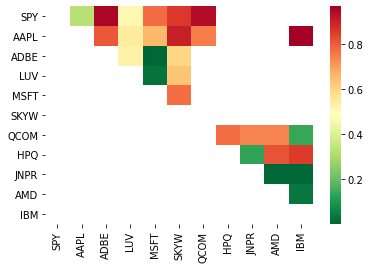

In [37]:
seaborn.heatmap(pvalues, xticklabels=symbolsIds,yticklabels=symbolsIds, cmap='RdYlGn_r', mask = (pvalues >= 0.98))

1. If a p-value is lower than 0.02, this means the null hypothesis is rejected.
2. This means that the two series of prices corresponding to two different symbols can be co-integrated.
3. This means that the two symbols will keep the same spread on average. On the heatmap, we observe that the following symbols have p-values lower than 0.02

Heatmap represnets the  measuring of the cointegration between a pair of symbols. If it is red, this means that the p-value is 1, which means that the null hypothesis is not rejected. Therefore, there is no significant evidence that the pair of symbols is co-integrated.

## Artifical Trading

Let's create a pair of symbols artificially to get an idea of how to trade

In [40]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt

let's create a symbol return that we will call `Symbol1`. The value of the Symbol1 price starts from a value of 10 and, every day, it will vary based on a random return (following a normal distribution). We will draw the price values by using the function plot of the matplotlib.pyplot package

In [41]:
np.random.seed(123)

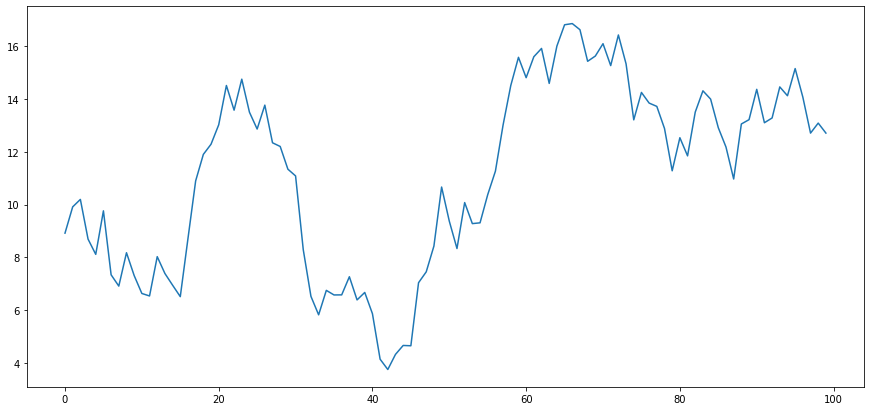

In [42]:
# Generating Symbol1 returns

Symbol1_returns = np.random.normal(0,1,100)

# Creating a series for Symbol1 Prices
Symbol1_prices = pd.Series(np.cumsum(Symbol1_returns),name='Symbol1') + 10

Symbol1_prices.plot(figsize=(15,7))
plt.show()

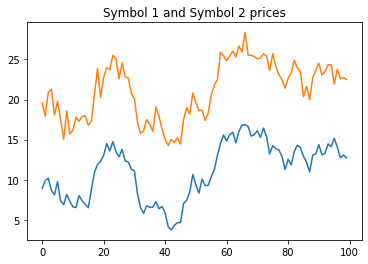

In [46]:
# Create a series for Symbol2 prices
# We will copy the Symbol1 behavior
noise = np.random.normal(0, 1, 100)
Symbol2_prices = Symbol1_prices + 10 + noise
Symbol2_prices.name = 'Symbol2'
plt.title("Symbol 1 and Symbol 2 prices")
Symbol1_prices.plot()
Symbol2_prices.plot()
plt.show()

In [48]:
core, pvalue, _ = coint(Symbol1_prices, Symbol2_prices)

In [49]:
pvalue

2.044324409938381e-13

We will define the zscore function. This function returns how far a piece of data is from the population mean. This will help us to choose the direction of trading.

If the return value of this function is positive, this means that the symbol price is higher than the average price value. Therefore, its price is expected to go down or the paired symbol value will go up. In this case, we will want to short this symbol and long the other one.

In [50]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

We will use the ratio between the two symbol prices. We will need to set the
threshold that defines when a given price is far off the mean price value. For that, we will need to use specific values for a given symbol. If we have many symbols we want to trade with, this will imply that this analysis be performed for all the symbols. Since we want to avoid this tedious work, we are going to normalize this study by analyzing the ratio of the two prices instead. As a result, we calculate the ratios of the `Symbol 1` price against the `Symbol 2` price.

<AxesSubplot:>

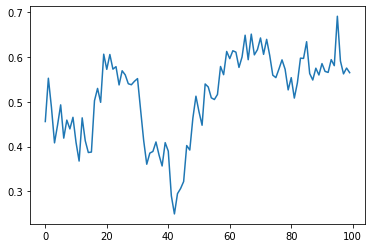

In [51]:
ratios = Symbol1_prices / Symbol2_prices
ratios.plot()


1. The Z-score evolution with horizontal lines at -1 (green), +1 (red), and the
average of Z-score (black).
2. The average of Z-score is 0.
3. When the Z-score reaches -1 or +1, we will use this event as a trading signal. The values +1 and -1 are arbitrary values.
4. It should be set depending on the study we will run in order to create this
trading strategy

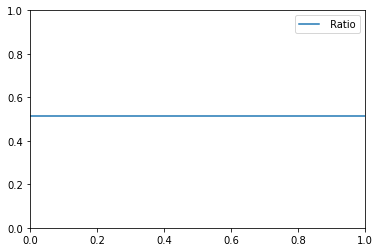

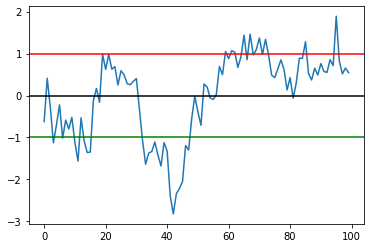

In [55]:
train = ratios[:75]
test = ratios[75:]
plt.axhline(ratios.mean())
plt.legend([' Ratio'])
plt.show()
zscore(ratios).plot()
plt.axhline(zscore(ratios).mean(),color="black")
plt.axhline(1.0, color="red")
plt.axhline(-1.0, color="green")
plt.show()

Every time the Z-score reaches one of the thresholds, we have a trading signal.
As shown in the code, we will present a graph, each time we go long for Symbol
1 with a green marker, and each time we go short with a red marker:

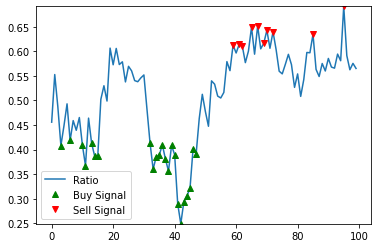

In [57]:
ratios.plot()
buy = ratios.copy()
sell = ratios.copy()
buy[zscore(ratios)>-1] = 0
sell[zscore(ratios)<1] = 0
buy.plot(color="g", linestyle="None", marker="^")
sell.plot(color="r", linestyle="None", marker="v")
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,ratios.min(),ratios.max()))
plt.legend(["Ratio", "Buy Signal", "Sell Signal"])
plt.show()

In this example, going long for Symbol 1 means that we will send a buy order for `Symbol 1`, while sending a sell order for `Symbol 2` concurrently.

In [66]:
symbol1_buy=Symbol1_prices.copy()
symbol1_sell=Symbol1_prices.copy()
symbol2_buy=Symbol2_prices.copy()
symbol2_sell=Symbol2_prices.copy()

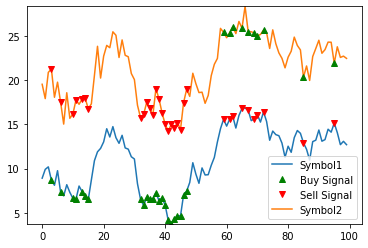

In [68]:
Symbol1_prices.plot()
symbol1_buy[zscore(ratios)>-1] = 0
symbol1_sell[zscore(ratios)<1] = 0
symbol1_buy.plot(color="g", linestyle="None", marker="^")
symbol1_sell.plot(color="r", linestyle="None", marker="v")

Symbol2_prices.plot()
symbol2_buy[zscore(ratios)<1] = 0
symbol2_sell[zscore(ratios)>-1] = 0
symbol2_buy.plot(color="g", linestyle="None", marker="^")
symbol2_sell.plot(color="r", linestyle="None", marker="v")


x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,Symbol1_prices.min(),Symbol2_prices.max()))
plt.legend(["Symbol1", "Buy Signal", "Sell Signal","Symbol2"])
plt.show()

Every time the Z-score reaches one of the thresholds, we have a trading signal.
As shown in the code, we will present a graph, each time we go long for Symbol
1 with a green marker, and each time we go short with a red marker:

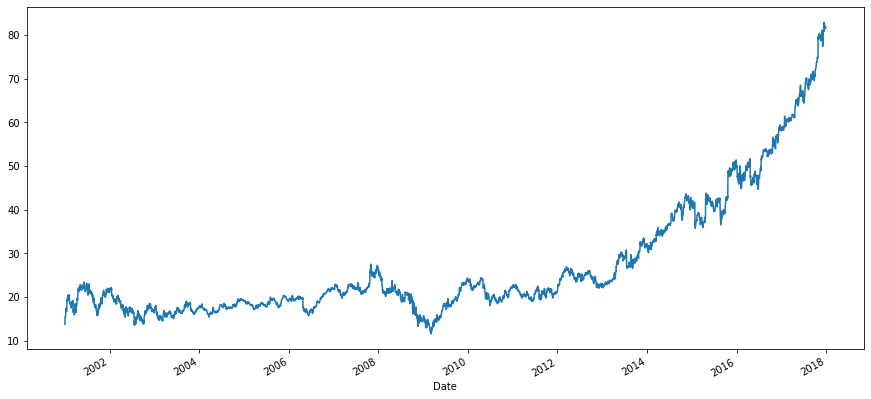

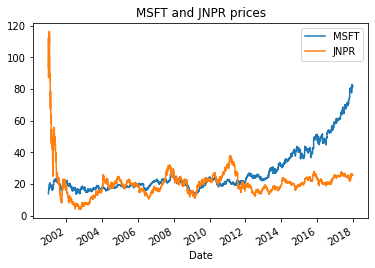

In [143]:
Symbol1_prices = data['Adj Close']['MSFT']
Symbol1_prices.plot(figsize=(15,7))
plt.show()
Symbol2_prices = data['Adj Close']['JNPR']
Symbol2_prices.name = 'JNPR'
plt.title("MSFT and JNPR prices")
Symbol1_prices.plot()
Symbol2_prices.plot()
plt.legend()
plt.show()

In [144]:
symbol1_buy=Symbol1_prices.copy()
symbol1_sell=Symbol1_prices.copy()
symbol2_buy=Symbol2_prices.copy()
symbol2_sell=Symbol2_prices.copy()

<AxesSubplot:xlabel='Date'>

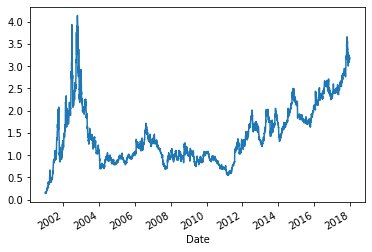

In [145]:
ratios = Symbol1_prices / Symbol2_prices
ratios.plot()


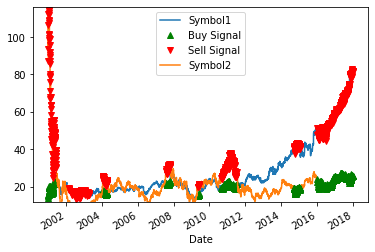

In [146]:
Symbol1_prices.plot()
symbol1_buy[zscore(ratios)>-1] = 0
symbol1_sell[zscore(ratios)<1] = 0
symbol1_buy.plot(color="g", linestyle="None", marker="^")
symbol1_sell.plot(color="r", linestyle="None", marker="v")

Symbol2_prices.plot()
symbol2_buy[zscore(ratios)<1] = 0
symbol2_sell[zscore(ratios)>-1] = 0
symbol2_buy.plot(color="g", linestyle="None", marker="^")
symbol2_sell.plot(color="r", linestyle="None", marker="v")


x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,Symbol1_prices.min(),Symbol2_prices.max()))
plt.legend(["Symbol1", "Buy Signal", "Sell Signal","Symbol2"])
plt.show()

This chart reveals a large quantity of orders. The pair correlation strategy without limitation sends too many orders. We can limit the number of orders in the same way we did previously:
1. Limiting positions
2. Limiting the number of orders
3. Setting a higher Z-score threshold


While the Z-score value is above or below the
threshold limits (in this example, -1 or +1), a Z-score value within the range
between the threshold limits denotes an improbable change of spread between
the two symbol prices. Therefore, when this value is within this limit, this can be
regarded as an exit signal

We will create a data frame, pair_correlation_trading_strategy, in the
code. This contains information relating to orders and position and we will use
this data frame to calculate the performance of this pair correlation trading
strategy:

In [147]:
pair_correlation_trading_strategy = pd.DataFrame(index=Symbol1_prices.index)
pair_correlation_trading_strategy['symbol1_price']= Symbol1_prices
pair_correlation_trading_strategy['symbol1_buy']=np.zeros(len(Symbol1_prices))
pair_correlation_trading_strategy['symbol1_sell']=np.zeros(len(Symbol1_prices))
pair_correlation_trading_strategy['symbol2_buy']=np.zeros(len(Symbol1_prices))
pair_correlation_trading_strategy['symbol2_sell']=np.zeros(len(Symbol1_prices))


In [148]:
pair_correlation_trading_strategy

,symbol1_price,symbol1_buy,symbol1_sell,symbol2_buy,symbol2_sell
Date,,,,,
2001-01-02,13.743100,0.0,0.0,0.0,0.0
2001-01-03,15.188696,0.0,0.0,0.0,0.0
2001-01-04,15.347120,0.0,0.0,0.0,0.0
2001-01-05,15.564948,0.0,0.0,0.0,0.0
2001-01-08,15.505532,0.0,0.0,0.0,0.0
...,...,...,...,...,...
2017-12-22,81.585175,0.0,0.0,0.0,0.0
2017-12-26,81.480217,0.0,0.0,0.0,0.0
2017-12-27,81.775978,0.0,0.0,0.0,0.0


We will limit the number of orders by reducing the position to one share. This
can be a long or short position. For a given symbol, when we have a long
position, a sell order is the only one that is allowed. When we have a short
position, a buy order is the only one that is allowed. When we have no position,
we can either go long (by buying) or go short (by selling). We will store the price
we use to send the orders. For the paired symbol, we will do the opposite. When
we sell Symbol 1, we will buy Symbol 2, and vice versa

In [150]:
position = 0
for i in range(len(Symbol1_prices)):
    s1price = Symbol1_prices[i]
    s2price = Symbol2_prices[i]
    
    if not position and symbol1_buy[i]!=0:
        pair_correlation_trading_strategy['symbol1_buy'][i] = s1price
        pair_correlation_trading_strategy['symbol2_sell'][i] = s2price
        position = 1
    elif not position and symbol1_sell[i] != 0:
        pair_correlation_trading_strategy['symbol1_sell'][i] = s1price
        pair_correlation_trading_strategy['symbol2_buy'][i] = s2price
        position = -1
    elif position==-1 and (symbol1_sell[i]==0 or i==len(Symbol1_prices)-1):
        pair_correlation_trading_strategy['symbol1_buy'][i] = s1price
        pair_correlation_trading_strategy['symbol2_sell'][i] = s2price
        position = 0
    elif position==1 and (symbol1_buy[i] == 0 or i==len(Symbol1_prices)-1):
        pair_correlation_trading_strategy['symbol1_sell'][i] = s1price
        pair_correlation_trading_strategy['symbol2_buy'][i] = s2price
        position = 0

In [153]:
pair_correlation_trading_strategy

,symbol1_price,symbol1_buy,symbol1_sell,symbol2_buy,symbol2_sell,symbol1_position
Date,,,,,,
2001-01-02,13.743100,13.743100,0.0,0.0,87.249001,13.743100
2001-01-03,15.188696,0.000000,0.0,0.0,0.000000,0.000000
2001-01-04,15.347120,0.000000,0.0,0.0,0.000000,0.000000
2001-01-05,15.564948,0.000000,0.0,0.0,0.000000,0.000000
2001-01-08,15.505532,0.000000,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...
2017-12-22,81.585175,0.000000,0.0,0.0,0.000000,0.000000
2017-12-26,81.480217,0.000000,0.0,0.0,0.000000,0.000000
2017-12-27,81.775978,0.000000,0.0,0.0,0.000000,0.000000


In [152]:
pair_correlation_trading_strategy['symbol1_position']= pair_correlation_trading_strategy['symbol1_buy']-pair_correlation_trading_strategy['symbol1_sell']

In [154]:
pair_correlation_trading_strategy['symbol2_position']= pair_correlation_trading_strategy['symbol2_buy']- pair_correlation_trading_strategy['symbol2_sell']

<AxesSubplot:xlabel='Date'>

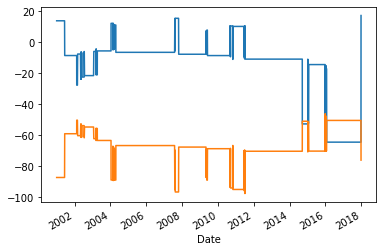

In [155]:
pair_correlation_trading_strategy['symbol1_position'].cumsum().plot() # Calculate Symbol 1 P&L
pair_correlation_trading_strategy['symbol2_position'].cumsum().plot() # Calculate Symbol 2 P&L

<AxesSubplot:xlabel='Date'>

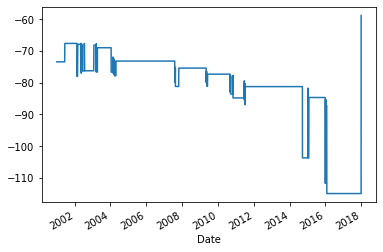

In [157]:
pair_correlation_trading_strategy['total_position']=pair_correlation_trading_strategy['symbol1_position']+pair_correlation_trading_strategy['symbol2_position'] # Calculate total P&L
pair_correlation_trading_strategy['total_position'].cumsum().plot()
